<a href="https://colab.research.google.com/github/giannismantzaris-cmd/DAMA61/blob/main/Mantzaris_WA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#All needed imports
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans




In [ ]:
# Load dataset
data = load_breast_cancer()

# Create a DataFrame with all features
X = pd.DataFrame(data.data, columns=data.feature_names)

# Target variable
y = pd.Series(data.target)

In [ ]:
# Dataset shape
print("Dataset shape:", X.shape)

Dataset shape: (569, 30)


In [ ]:
# Class distribution
print("Target class distribution:")
print(y.value_counts())

Target class distribution:
1    357
0    212
Name: count, dtype: int64


In [ ]:
# Target label names
print("\nTarget names:", data.target_names)


Target names: ['malignant' 'benign']


The dataset consists of 569 samples, each described by 30 numerical features.
The target variable is binary, with class 0 corresponding to malignant tumors and class 1 to benign tumors.
The class distribution reveals an imbalance towards class 1 (benign tumors).

In [ ]:
# Missing values
X.isna().sum()

,0
mean radius,0
mean texture,0
mean perimeter,0
mean area,0
mean smoothness,0
mean compactness,0
mean concavity,0
mean concave points,0
mean symmetry,0
mean fractal dimension,0


In [ ]:
# Duplicate rows
X.duplicated().sum()

np.int64(0)

In [ ]:
# Top 5 features with highest standard deviation

feature_std = X.std()
feature_std_sorted = feature_std.sort_values(ascending=False)
top5_std = feature_std_sorted.head(5)
top5_std

,0
worst area,569.356993
mean area,351.914129
area error,45.491006
worst perimeter,33.602542
mean perimeter,24.298981


In [ ]:
#Stratified train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [ ]:
#Decision Tree without scaling
dt_no_scaling = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_no_scaling.fit(X_train, y_train)

y_pred_no_scaling = dt_no_scaling.predict(X_test)

In [ ]:
# Decision Tree with RobustScaler - using a pipeline to ensure proper scaling
dt_with_scaling = Pipeline([("scaler", RobustScaler()),("tree", DecisionTreeClassifier(max_depth=3, random_state=42))])

dt_with_scaling.fit(X_train, y_train)

y_pred_with_scaling = dt_with_scaling.predict(X_test)

In [ ]:
#Compaire test set predictions regarding their similarity.
check_identical = (y_pred_no_scaling == y_pred_with_scaling).all()
check_identical

np.True_

The 2 models have identical predictions. This is expected because DT models rely on threshold based splits rather than distance measures or inner products, so feature scaling does not affect their predictions.

In [ ]:
# Export the tree structure in text form
tree_structure = export_text(dt_no_scaling, feature_names=list(X.columns))
tree_structure

'|--- worst radius <= 16.80\n|   |--- worst concave points <= 0.14\n|   |   |--- area error <= 91.56\n|   |   |   |--- class: 1\n|   |   |--- area error >  91.56\n|   |   |   |--- class: 0\n|   |--- worst concave points >  0.14\n|   |   |--- worst texture <= 25.62\n|   |   |   |--- class: 1\n|   |   |--- worst texture >  25.62\n|   |   |   |--- class: 0\n|--- worst radius >  16.80\n|   |--- texture error <= 0.47\n|   |   |--- class: 1\n|   |--- texture error >  0.47\n|   |   |--- worst concavity <= 0.19\n|   |   |   |--- class: 1\n|   |   |--- worst concavity >  0.19\n|   |   |   |--- class: 0\n'

In [ ]:
# Total number of leaves
num_leaves = dt_no_scaling.get_n_leaves()
num_leaves

np.int64(7)

The root node’s splitting feature is worst radius, and the tree has 7 leaves.

In [ ]:
#Simple RF (no preprocessing)
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {"n_estimators": [50, 100],"max_depth": [3, 5, 10]}

start_time = time.time()

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring="roc_auc")

grid_rf.fit(X_train, y_train)

train_time_rf = time.time() - start_time

In [ ]:
#Evaluate simple RF in test set
best_rf = grid_rf.best_estimator_

y_test_prob_rf = best_rf.predict_proba(X_test)[:, 1]
y_test_pred_rf = best_rf.predict(X_test)

roc_auc_test_rf = roc_auc_score(y_test, y_test_prob_rf)
acc_test_rf = accuracy_score(y_test, y_test_pred_rf)

In [ ]:
print("Simple RF")

print("Mean ROC-AUC (training set)", grid_rf.best_score_)
print("ROC-AUC (test set)", roc_auc_test_rf)
print("Accuracy (test set)", acc_test_rf)
print("Training time (seconds)", train_time_rf)
print("Best hyperparameters", grid_rf.best_params_)

Simple RF
Mean ROC-AUC (training set) 0.9888544891640867
ROC-AUC (test set) 0.9933862433862434
Accuracy (test set) 0.956140350877193
Training time (seconds) 8.5508291721344
Best hyperparameters {'max_depth': 5, 'n_estimators': 100}


In [ ]:
#RF with PCA & standard scaler
pipe_pca = Pipeline([("scaler", StandardScaler()), ("pca", PCA()), ("rf", RandomForestClassifier(random_state=42))])

param_grid_pca = {"pca__n_components": [10, 20, 30], "rf__n_estimators": [50, 100], "rf__max_depth": [3, 5, 10]}

start_time = time.time()

grid_pca = GridSearchCV(pipe_pca, param_grid_pca, cv=5, scoring="roc_auc")

grid_pca.fit(X_train, y_train)

train_time_pca = time.time() - start_time


In [ ]:
#Evaluate RF with PCA & standard scaler in test set
best_pca = grid_pca.best_estimator_

y_test_prob_pca = best_pca.predict_proba(X_test)[:, 1]
y_test_pred_pca = best_pca.predict(X_test)

roc_auc_test_pca = roc_auc_score(y_test, y_test_prob_pca)
acc_test_pca = accuracy_score(y_test, y_test_pred_pca)

In [ ]:
print("RF with PCA & standard scaler")

print("Mean ROC-AUC (training set)", grid_pca.best_score_)
print("ROC-AUC (test set)", roc_auc_test_pca)
print("Accuracy (test set)", acc_test_pca)
print("Training time (seconds)", train_time_pca)
print("Best hyperparameters", grid_pca.best_params_)

RF with PCA & standard scaler
Mean ROC-AUC (training set) 0.9889576883384933
ROC-AUC (test set) 0.9847883597883598
Accuracy (test set) 0.9210526315789473
Training time (seconds) 18.33741569519043
Best hyperparameters {'pca__n_components': 10, 'rf__max_depth': 10, 'rf__n_estimators': 100}


In [ ]:
#RF with LLE (Locally Linear Embedding)
pipe_lle = Pipeline([("scaler", StandardScaler()), ("lle", LocallyLinearEmbedding()), ("rf", RandomForestClassifier(random_state=42))])

param_grid_lle = {"lle__n_components": [10, 15], "lle__n_neighbors": [5, 10, 15], "rf__n_estimators": [50, 100], "rf__max_depth": [3, 5, 10]}

start_time = time.time()

grid_lle = GridSearchCV(pipe_lle, param_grid_lle, cv=5, scoring="roc_auc")

grid_lle.fit(X_train, y_train)

train_time_lle = time.time() - start_time

In [ ]:
#Evaluate RF with LLE & standard scaler in test set

best_lle = grid_lle.best_estimator_

y_test_prob_lle = best_lle.predict_proba(X_test)[:, 1]
y_test_pred_lle = best_lle.predict(X_test)

roc_auc_test_lle = roc_auc_score(y_test, y_test_prob_lle)
acc_test_lle = accuracy_score(y_test, y_test_pred_lle)

In [ ]:
print("RF with LLE & standard scaler")

print("Mean ROC-AUC (training set)", grid_lle.best_score_)
print("ROC-AUC (test set)", roc_auc_test_lle)
print("Accuracy (test set)", acc_test_lle)
print("Training time (seconds)", train_time_lle)
print("Best hyperparameters", grid_lle.best_params_)

RF with LLE & standard scaler
Mean ROC-AUC (training set) 0.9910216718266254
ROC-AUC (test set) 0.9775132275132276
Accuracy (test set) 0.9298245614035088
Training time (seconds) 56.109917402267456
Best hyperparameters {'lle__n_components': 15, 'lle__n_neighbors': 5, 'rf__max_depth': 5, 'rf__n_estimators': 100}


Among the three Random Forest variants, the simple Random Forest without preprocessing achieved the best overall performance, as it achieved the highest ROC-AUC and accuracy on the test set while also requiring the least training time.
The PCA-based model did not improve performance, while it added computational costs, and the LLE-based model was significantly more computationally expensive while also performing slightly worse that the simple RF.
This behavior is expected, as Random Forests are well suited to tabular data and do not typically benefit from dimensionality reduction techniques.

PROBLEM 2

In [2]:
import pandas as pd

col_names = ["Profile_mean", "Profile_std", "Profile_kurtosis", "Profile_skewness", "DM_mean", "DM_std", "DM_kurtosis", "DM_skewness", "class"]

df = pd.read_csv("/content/HTRU_2.csv", header=None, names=col_names)

In [3]:
#shape of the dataset, column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      17898 non-null  float64
 1   Profile_std       17898 non-null  float64
 2   Profile_kurtosis  17898 non-null  float64
 3   Profile_skewness  17898 non-null  float64
 4   DM_mean           17898 non-null  float64
 5   DM_std            17898 non-null  float64
 6   DM_kurtosis       17898 non-null  float64
 7   DM_skewness       17898 non-null  float64
 8   class             17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


In [4]:
#inspect a few initial values
df.head()

,Profile_mean,Profile_std,Profile_kurtosis,Profile_skewness,DM_mean,DM_std,DM_kurtosis,DM_skewness,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [5]:
# compute descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Profile_mean,17898.0,111.079968,25.652935,5.812500,100.929688,115.078125,127.085938,192.617188
Profile_std,17898.0,46.549532,6.843189,24.772042,42.376018,46.947479,51.023202,98.778911
Profile_kurtosis,17898.0,0.477857,1.064040,-1.876011,0.027098,0.223240,0.473325,8.069522
Profile_skewness,17898.0,1.770279,6.167913,-1.791886,-0.188572,0.198710,0.927783,68.101622
DM_mean,17898.0,12.614400,29.472897,0.213211,1.923077,2.801839,5.464256,223.392141
DM_std,17898.0,26.326515,19.470572,7.370432,14.437332,18.461316,28.428104,110.642211
DM_kurtosis,17898.0,8.303556,4.506092,-3.139270,5.781506,8.433515,10.702959,34.539844
DM_skewness,17898.0,104.857709,106.514540,-1.976976,34.960504,83.064556,139.309330,1191.000837
class,17898.0,0.091574,0.288432,0.000000,0.000000,0.000000,0.000000,1.000000


In [6]:
#check number of missing values per column
df.isna().sum()

,0
Profile_mean,0
Profile_std,0
Profile_kurtosis,0
Profile_skewness,0
DM_mean,0
DM_std,0
DM_kurtosis,0
DM_skewness,0
class,0


In [7]:
#check for imbalance
df["class"].value_counts()

,count
class,
0,16259
1,1639


The descriptive statistics show that the features have very different scales and distributions, with some variables exhibiting large ranges and extreme values. No missing data are present, so no imputation is required.

The necessity of preprocessing depends on the method used.

For Random Forests, no feature scaling or transformation is required, as RF do not rely on distance calculations, and they are robust to differences in feature scale, skewed distributions, and outliers.

On the other hand, k-means clustering and t-SNE are distance based methods that rely on euclidean distances. As a result, they are highly sensitive to differences in feature scale, such as the oned present in our dataset. Feature standardization is necessary before applying these methods to ensure that no single feature dominates the distance calculations.

Finally, we notice that the dataset is highly imbalanced. This does not require any feature transformations, it concerns the target variable and not the input features,but it should be taken into account in the data splitting and model evaluation.

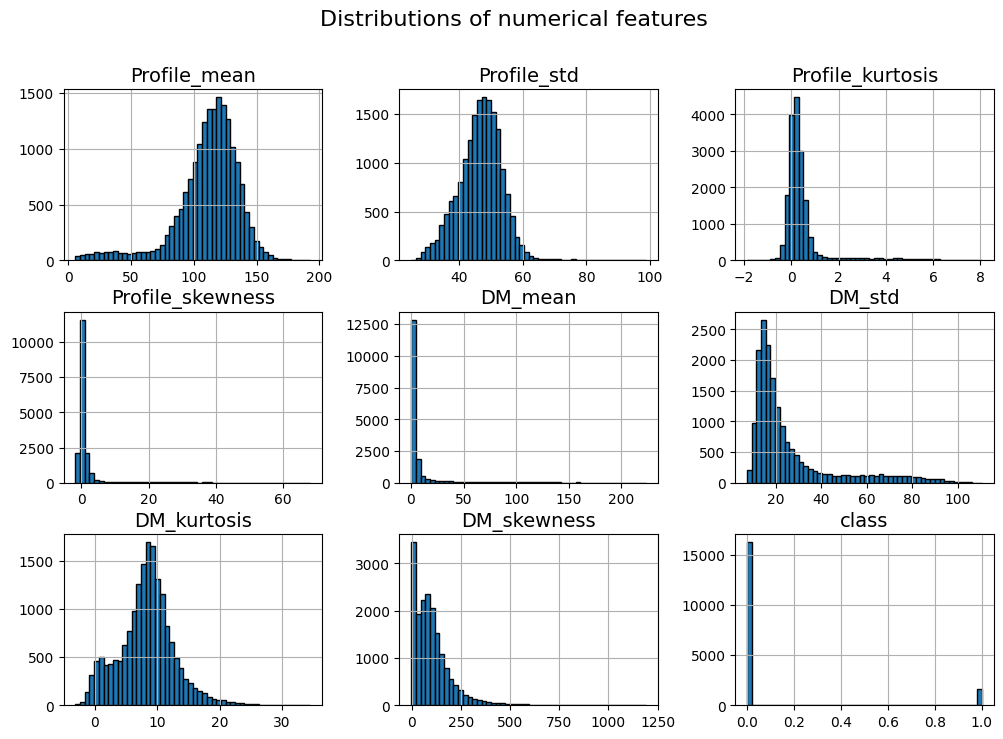

In [8]:
#extra step - check the distribution of numerical features for next steps. Visualize to confirm the need to scale in distance based models, confirm presence of skewed variables
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8), edgecolor="black")
plt.suptitle("Distributions of numerical features", fontsize=16)
plt.show()

In [9]:
#Set X = features, y = target
X = df.drop(columns="class")
y = df["class"]

# Stratified split to ensure we retain the distrivution of the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
#Compare the distribution of the target variable in the training and test sets and verify it’s similar.
y_train.value_counts(normalize=True)

,proportion
class,
0,0.908437
1,0.091563


In [11]:
y_test.value_counts(normalize=True)

,proportion
class,
0,0.90838
1,0.09162


The proportions are almost excactly the same, about 90% of the target variable is class 0 and 10% is class 1 in both training and test sets

In [12]:
#design a pipeline consisting of all necessary preprocessing followed by a Random Forest classifier.
rf_pipe = Pipeline(steps=[("rf", RandomForestClassifier(random_state=42,))])
rf_pipe

Pipeline(steps=[('rf', RandomForestClassifier(random_state=42))])

In [13]:
#Set hyperparameter values as given
param_grid = {"rf__n_estimators": [50, 100], "rf__min_samples_leaf": [1, 5], "rf__max_depth": [10, None]}


In [14]:
grid = GridSearchCV(estimator=rf_pipe, param_grid=param_grid, cv=5, scoring="roc_auc",)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rf',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'rf__max_depth': [10, None],
                         'rf__min_samples_leaf': [1, 5],
                         'rf__n_estimators': [50, 100]},
             scoring='roc_auc')

In [15]:
#Check which values lead to the best performance
grid.best_score_

np.float64(0.9758226794448648)

In [16]:
grid.best_params_

{'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 100}

The best model uses 100 estimators, a maximum depth of 10, and 5 samples per leaf, achieving a mean cross-validated ROC-AUC of 0.976.

In [17]:
#Use the best-performing model to classify the test set, print the classification report, and comment on the results.
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Classification report (test set):")
print(classification_report(y_test, y_pred))

Classification report (test set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3252
           1       0.92      0.86      0.89       328

    accuracy                           0.98      3580
   macro avg       0.96      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



The model achieves very high overall performance. Regrding the non-pulsar class, it achieves an almost perfect precision and recall (99%). For the pulsar class, the model achieves high precision (92%) and good recall (86%), indicating that most pulsars are correctly identified, although some are still missed. This is expected given the strong class imbalance and shows that the Random Forest model performs well demonstrating effective discrimination despite class imbalance.

In [18]:
#Extract the trained Random Forest from the pipeline
rf_model = best_model.named_steps["rf"]

In [19]:
#Get feature importances
importances = rf_model.feature_importances_

In [20]:
#present the results
feature_importance_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df

,feature,importance
2,Profile_kurtosis,0.408516
3,Profile_skewness,0.231247
0,Profile_mean,0.153743
4,DM_mean,0.062969
5,DM_std,0.053219
7,DM_skewness,0.033019
1,Profile_std,0.031848
6,DM_kurtosis,0.025439


In [22]:
k_values = [5, 10, 25]

In [28]:
for k in k_values:

    print(f"Running representative selection for k = {k}")
    print("-"*50)

    # --- split training data by class ---
    X_pos = X_train[y_train == 1]
    X_neg = X_train[y_train == 0]

    n_pos = len(X_pos)
    n_neg = len(X_neg)

    ratio = n_neg / n_pos
    k_neg = int(round(ratio * k))

    print("k (positives):", k)
    print("k_neg (negatives):", k_neg)

    # --- k-means on POSITIVES ---
    scaler_pos = StandardScaler()
    X_pos_scaled = scaler_pos.fit_transform(X_pos)

    kmeans_pos = KMeans(n_clusters=k, random_state=42, n_init=10)
    distances_pos = kmeans_pos.fit_transform(X_pos_scaled)

    rep_idx_pos = distances_pos.argmin(axis=0)
    X_rep_pos = X_pos.iloc[rep_idx_pos]

    # --- k-means on NEGATIVES ---
    scaler_neg = StandardScaler()
    X_neg_scaled = scaler_neg.fit_transform(X_neg)

    kmeans_neg = KMeans(
        n_clusters=k_neg,
        random_state=42,
        n_init=10
    )

    distances_neg = kmeans_neg.fit_transform(X_neg_scaled)

    rep_idx_neg = distances_neg.argmin(axis=0)
    X_rep_neg = X_neg.iloc[rep_idx_neg]


    # --- merge representatives ---
    X_rep = pd.concat([X_rep_pos, X_rep_neg], axis=0)
    y_rep = pd.Series(
        [1]*len(X_rep_pos) + [0]*len(X_rep_neg),
        index=X_rep.index
    )

    print("Representative set size:", len(X_rep))
    print("Pos reps:", len(X_rep_pos), "Neg reps:", len(X_rep_neg))

    # --- RF + GridSearchCV ---
    rf_pipe = Pipeline([
        ("rf", RandomForestClassifier(random_state=42))
    ])

    grid = GridSearchCV(
        rf_pipe,
        param_grid=param_grid,
        cv=5,
        scoring="roc_auc"
    )

    grid.fit(X_rep, y_rep)

    print("Best CV ROC-AUC:", grid.best_score_)
    print("Best params:", grid.best_params_)

    # --- test evaluation ---
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    print("\nClassification report (test set):")
    print(classification_report(y_test, y_pred))


Running representative selection for k = 5
--------------------------------------------------
k (positives): 5
k_neg (negatives): 50
Representative set size: 55
Pos reps: 5 Neg reps: 50
Best CV ROC-AUC: 0.74
Best params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 50}

Classification report (test set):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3252
           1       0.00      0.00      0.00       328

    accuracy                           0.91      3580
   macro avg       0.45      0.50      0.48      3580
weighted avg       0.83      0.91      0.86      3580

Running representative selection for k = 10
--------------------------------------------------
k (positives): 10
k_neg (negatives): 99


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Representative set size: 109
Pos reps: 10 Neg reps: 99
Best CV ROC-AUC: 0.8400000000000001
Best params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 50}

Classification report (test set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3252
           1       0.97      0.56      0.71       328

    accuracy                           0.96      3580
   macro avg       0.97      0.78      0.85      3580
weighted avg       0.96      0.96      0.95      3580

Running representative selection for k = 25
--------------------------------------------------
k (positives): 25
k_neg (negatives): 248
Representative set size: 273
Pos reps: 25 Neg reps: 248
Best CV ROC-AUC: 0.8842122448979592
Best params: {'rf__max_depth': 10, 'rf__min_samples_leaf': 5, 'rf__n_estimators': 100}

Classification report (test set):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3252
  